Using device: cpu
Epoch 1/50 - Loss: 2.2042
Epoch 2/50 - Loss: 1.8379
Epoch 3/50 - Loss: 1.2728
Epoch 4/50 - Loss: 0.7501
Epoch 5/50 - Loss: 0.4433
Epoch 6/50 - Loss: 0.2878
Epoch 7/50 - Loss: 0.2043
Epoch 8/50 - Loss: 0.1566
Epoch 9/50 - Loss: 0.1244
Epoch 10/50 - Loss: 0.1013
Epoch 11/50 - Loss: 0.0851
Epoch 12/50 - Loss: 0.0719
Epoch 13/50 - Loss: 0.0622
Epoch 14/50 - Loss: 0.0537
Epoch 15/50 - Loss: 0.0464
Epoch 16/50 - Loss: 0.0407
Epoch 17/50 - Loss: 0.0361
Epoch 18/50 - Loss: 0.0318
Epoch 19/50 - Loss: 0.0284
Epoch 20/50 - Loss: 0.0254
Epoch 21/50 - Loss: 0.0227
Epoch 22/50 - Loss: 0.0205
Epoch 23/50 - Loss: 0.0186
Epoch 24/50 - Loss: 0.0168
Epoch 25/50 - Loss: 0.0152
Epoch 26/50 - Loss: 0.0138
Epoch 27/50 - Loss: 0.0128
Epoch 28/50 - Loss: 0.0115
Epoch 29/50 - Loss: 0.0108
Epoch 30/50 - Loss: 0.0098
Epoch 31/50 - Loss: 0.0090
Epoch 32/50 - Loss: 0.0084
Epoch 33/50 - Loss: 0.0078
Epoch 34/50 - Loss: 0.0072
Epoch 35/50 - Loss: 0.0066
Epoch 36/50 - Loss: 0.0063
Epoch 37/50 - Loss:

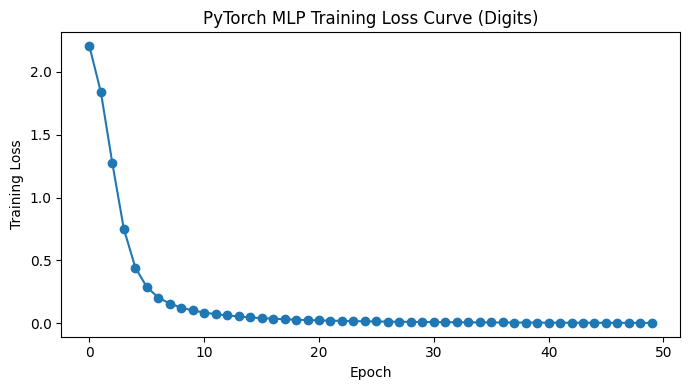

<Figure size 700x600 with 0 Axes>

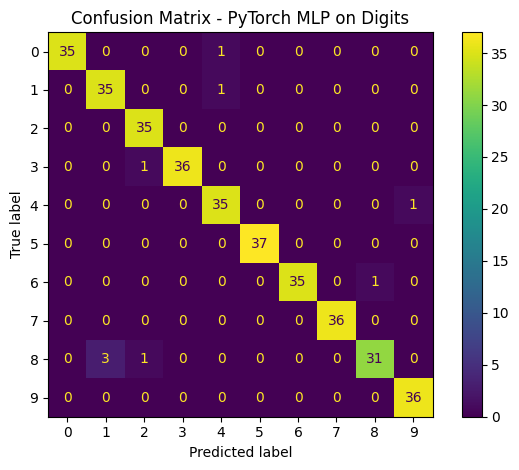

In [16]:
"""
Demo: Multi-Layer Perceptron (MLP) on scikit-learn Digits dataset using PyTorch

Steps:
1) Load the 8x8 handwritten digits dataset (1797 samples)
2) Split into train/test
3) Scale features (very important for MLP)
4) Build an MLP in PyTorch
5) Train with mini-batches using Adam optimizer
6) Evaluate accuracy and F1
7) Plot training loss and confusion matrix
"""

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix,
    ConfusionMatrixDisplay, classification_report
)

# PyTorch: A tensor-based deep learning framework 
# PyTorch’s Python package name: torch
# A tensor is just a container for numbers that can have any number of dimensions
# Everything in PyTorch — neural networks, layers, losses, optimizers, gradients — 
# is built to work with torch.Tensor, not NumPy arrays.

# NumPy = calculator
# PyTorch = calculator + GPU + automatic differentiation + neural network tools

import torch
import torch.nn as nn # Neural network layers
import torch.optim as optim # Optimization algorithms (Adam, SGD, etc.)
from torch.utils.data import TensorDataset #a dataset wrapper around tensors
from torch.utils.data import DataLoader #a tool that automatically creates batches and shuffles data

# ---------------------------
# 1. Define MLP model in PyTorch
# ---------------------------
class MLP(nn.Module):
    def __init__(self, input_dim=64, hidden1=64, hidden2=32, num_classes=10):
        super().__init__()
        # Define the Layers
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, num_classes)
        )

    def forward(self, x):
        # x: (batch_size, input_dim)
        return self.net(x) # self.net(x) automatically runs it through all layers in order


def main():
    # Choose device (GPU if available, otherwise CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # ---------------------------
    # 2. Load data
    # ---------------------------
    digits = load_digits()
    X = digits.data          # shape: (n_samples, 64) flattened 8x8 images
    y = digits.target        # labels: 0..9

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # ---------------------------
    # 3. Scale features (standardization)
    # ---------------------------
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    # ---------------------------
    # 4. Convert to PyTorch tensors and DataLoaders
    # ---------------------------
    # Converts X_train_scaled (NumPy array) -> X_train_tensor (PyTorch tensor) so PyTorch can use them for training on CPU or GPU.
    # Feature matrices X Must use float32 because neural network weights are floats
    # Labels y Must be dtype=torch.long because nn.CrossEntropyLoss() requires integer class labels
    
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)

    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    # Create datasets that pair (X, y) together
    # Makes batching easy
    # Makes shuffling easy
    
    train_ds = TensorDataset(X_train_tensor, y_train_tensor)
    test_ds  = TensorDataset(X_test_tensor, y_test_tensor)

    # Build DataLoaders for mini-batch training
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    # Testing does not backpropagate = no gradients
    # Larger batches makes evaluation faster, No need to shuffle
    test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False)

    
    # ---------------------------
    # 5. Create model, loss function, optimizer
    # ---------------------------
    # Build the model
    model = MLP(input_dim=64, hidden1=64, hidden2=32, num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss() # Define the loss function
    optimizer = optim.Adam(model.parameters(), lr=1e-3) #Choose the optimizer
    # model.parameters() gives Adam access to all weights and biases in the network.
    # So the optimizer can update them during training.
    
    # ---------------------------
    # 6. Training loop
    # ---------------------------
    num_epochs = 50
    epoch_losses = []

    model.train() # tells PyTorch turn on the training behavior for all layers
    for epoch in range(num_epochs):
        running_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # 1) Zero gradients
            optimizer.zero_grad()

            # 2) Forward pass
            outputs = model(X_batch)        # shape: (batch_size, 10)

            # 3) Compute loss
            loss = criterion(outputs, y_batch)

            # 4) Backward pass
            loss.backward() # computes gradients with respect to all model parameters (weights & biases)

            # 5) Update weights
            optimizer.step() # gradient descent

            running_loss += loss.item() * X_batch.size(0) 
            # loss.item() is average loss per sample in the batch 
            # loss = (loss_1 + loss_2 + ... + loss_64) / 64
            # loss.item() * X_batch.size(0) is the total loss in the batch

        # Average loss over the epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}")

    # ---------------------------
    # 7. Evaluation on test set
    # ---------------------------
    model.eval() # Switch model to evaluation mode
    all_preds = []
    all_true  = []

    with torch.no_grad(): # Disable gradient computation
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch)             # (batch_size, 10)
            preds = torch.argmax(outputs, dim=1) # Convert scores to predicted digit

            all_preds.append(preds.cpu().numpy()) # Convert tensors back to NumPy arrays
            all_true.append(y_batch.cpu().numpy())

    y_pred = np.concatenate(all_preds) # Combine all test batches
    y_true = np.concatenate(all_true)

    acc = accuracy_score(y_true, y_pred)
    f1w = f1_score(y_true, y_pred, average='weighted') # F1-weighted = F1 score weighted by class frequency
    f1m = f1_score(y_true, y_pred, average='macro') # F1-macro = average F1 across all classes

    print(f"\nAccuracy: {acc:.4f} | F1 (weighted): {f1w:.4f} | F1 (macro): {f1m:.4f}")
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, digits=4))

    # ---------------------------
    # 8. Plot training loss curve
    # ---------------------------
    plt.figure(figsize=(7,4))
    plt.plot(epoch_losses, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.title("PyTorch MLP Training Loss Curve (Digits)")
    plt.tight_layout()
    plt.show()

    # ---------------------------
    # 9. Confusion Matrix
    # ---------------------------
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=digits.target_names)
    plt.figure(figsize=(7,6))
    disp.plot(values_format='d')
    plt.title("Confusion Matrix - PyTorch MLP on Digits")
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()


In [11]:
# Precision=TP/(TP+FP)

In [12]:
# Recall(Sensitivity)=TP/(TP+FN)

In [13]:
# F1 Score = 2 × (Precision×Recall)/(Precision+Recall)